In [1]:
import yfinance as yf
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from fredapi import Fred

% of >= SP500 (ave diff): 60.0 (10.97)


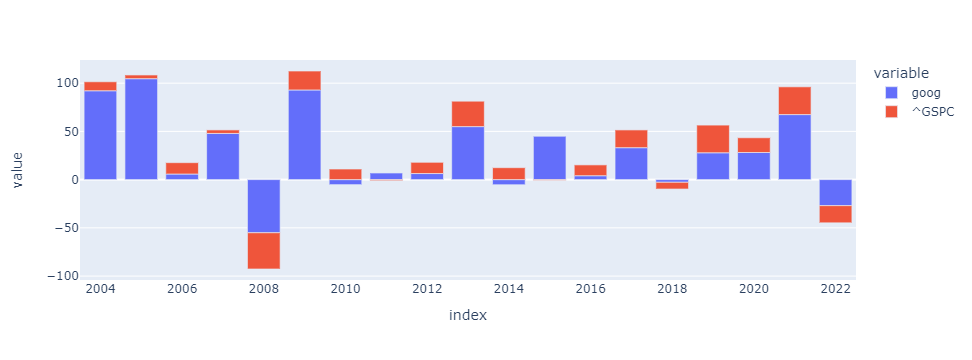

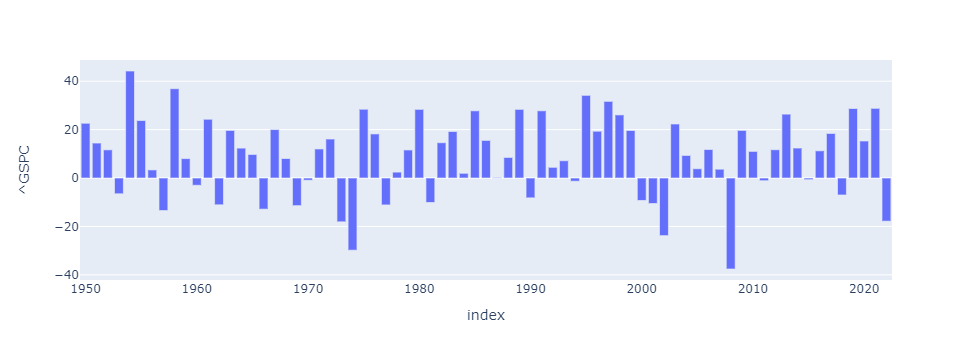

In [93]:
##### % change by year (sp500: ^GSPC, nasdaq: ^IXIC,  vix: ^VIX, Dow Jones: ^DJI)
def dfyrpchg(ticker):
    stock = yf.Ticker(ticker)
    sk = stock.history(period = 'max')
    yrs = np.unique(sk.index.year)
    pchgs = []
    for yr in np.unique(sk.index.year):
        sk1y_cl = sk[sk.index.year == yr]['Close']
        pchg = (sk1y_cl[-1]/sk1y_cl[0] - 1)*100
        pchgs.append(pchg)
        
    dfskchg = pd.DataFrame(data = pchgs, index = yrs, columns = [ticker])
    return dfskchg

skchg1 = dfyrpchg('^GSPC')
skchg2 = dfyrpchg('goog') 
skchg = skchg2.join(skchg1)
skchg['diff'] = skchg.iloc[:, 0] - skchg.iloc[:, 1]

skchg_sub = skchg[-10:]
pgtsp500 = round(np.mean(skchg_sub.iloc[:, 0] >= skchg_sub.iloc[:, 1]), 3)*100
print('% of >= SP500 (ave diff):', pgtsp500, '('+str(round(np.mean(skchg_sub['diff']), 2))+')')

# plot change %
fig = px.bar(skchg, x = skchg.index, y = skchg.columns[:2])
fig.show()

fig1 = px.bar(skchg1, x = skchg1.index, y = '^GSPC')
fig1.show()

In [24]:
################# input ticker ###############
ticker = "amcr"
stock = yf.Ticker(ticker)

In [25]:
######################## financial report analysis ####################
unit = 'year'

if unit == 'quart':
    fin = stock.quarterly_financials
    bs = stock.quarterly_balance_sheet
    cfs = stock.quarterly_cashflow
elif unit == 'year':
    fin = stock.financials
    bs = stock.balance_sheet
    cfs = stock.cashflow

if(fin.shape[0] == 0):
    print('Invalid Ticker')
else:
    ## Ratio of totoal liab and total asset
    lia_ast = bs.loc['Total Liab', :]/bs.loc['Total Assets', :]

    ## Ratio of current totoal liab and current total asset
    lia_ast_cur = bs.loc['Total Current Liabilities', :]/bs.loc['Total Current Assets', :]
    
    ## cash/liab
    cash_lia_cur = bs.loc['Cash', :]/bs.loc['Total Current Liabilities', :]
    cash_lia = bs.loc['Cash', :]/bs.loc['Total Liab', :]
    
    ## (cash+short_term_invest)/laib
    if 'Short Term Investments' in bs.index:
        cain_lia_cur = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Current Liabilities', :]
        cain_lia = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Liab', :]
    else:
        cain_lia_cur = cash_lia_cur
        cain_lia = cash_lia 
    
    dfasset = [lia_ast_cur, lia_ast, cash_lia_cur, cash_lia, cain_lia_cur, cain_lia]
    asset_smry = pd.DataFrame(dfasset).T
    asset_smry.columns = ['Cur_Liab/Asset', 'Tot_Liab/Asset', 'Cur_Cash/Liab', 'Tot_Cash/Liab', 'Cur_C_STI/Liab', 'Tot_C_STI/Liab']
    
    ## gross
    rev_total = fin.loc['Total Revenue', :]
    rev_cost = fin.loc['Cost Of Revenue', :]
    gross_pchg = [round((rev_total[i]-rev_total[i+1])/rev_total[i+1]*100, 2) for i in range(len(rev_total)-1)]+[0]
    gross_pchg = pd.DataFrame(gross_pchg)
    gross_pchg.index = rev_total.index
  
    ## gross marging
    gmargin = (rev_total-rev_cost)/rev_total
    gmargin_pchg = [round((gmargin[i]-gmargin[i+1])/gmargin[i+1]*100, 2) for i in range(len(gmargin)-1)]+[0]
    gmargin_pchg = pd.DataFrame(gmargin_pchg)
    gmargin_pchg.index = gmargin.index
    
    gross_smry = pd.concat([rev_total, gross_pchg, gmargin, gmargin_pchg], axis = 1)
    gross_smry.columns = ['Gross', 'Gross_PCHG(%)', 'Gross_Margin', 'GM_PCHG(%)']
    
    ## net income
    ninc = fin.loc['Net Income', :]
    ninc_pchg_prev = [round((ninc[i] - ninc[i+1])/ninc[i+1]*100, 2) for i in range(len(ninc)-1)]+[0]
    ninc_pchg_prev = pd.DataFrame(ninc_pchg_prev)
    ninc_pchg_prev.index = ninc.index
    
    ninc_pchg = [round((ninc[i] - ninc[-1])/ninc[-1]*100, 2) for i in range(len(ninc))]
    ninc_pchg = pd.DataFrame(ninc_pchg)
    ninc_pchg.index = ninc.index
    
    ninc_smry = pd.concat([ninc, ninc_pchg_prev, ninc_pchg], axis = 1)
    ninc_smry.columns = ['Net Income', 'Net Income PCHG Prev(%)', 'Net Income PCHG(%)']
    
    ## free cash flow
    fcf = cfs.loc['Total Cash From Operating Activities', :] + cfs.loc['Capital Expenditures', :]
    fcfchg = list(round(-fcf.diff()/fcf, 3)[1:])+['NA']
    fcf = pd.DataFrame(fcf)
    fcf.columns = ['FCF']
    fcf['FCF Chg'] = fcfchg
    
    ## return on equity
    roes = [round(fin.loc['Net Income', :][i]/bs.loc['Total Stockholder Equity', :][i]*100, 2) for i in range(len(fin.loc['Net Income', :]))]
    roes = pd.DataFrame(roes)
    roes.index = fin.loc['Net Income', :].index
    roes.columns = ['Return on Equity(%)']
    
    ## PB ratio 
    pb_ratio = stock.info['marketCap']/bs.loc['Net Tangible Assets', :][0]
    
    ## summaries
    print(round(asset_smry, 3))
    print(gross_smry)
    print(ninc_smry)
    print(fcf)
    print(roes)
    print('PB Ratio: '+str(round(pb_ratio, 3)))

            Cur_Liab/Asset  Tot_Liab/Asset  Cur_Cash/Liab  Tot_Cash/Liab  \
                                                                           
2021-06-30           0.825           0.720          0.196          0.069   
2020-06-30           0.876           0.715          0.187          0.063   
2019-06-30           0.872           0.669          0.132          0.052   
2018-06-30           1.396           0.923          0.123          0.074   

            Cur_C_STI/Liab  Tot_C_STI/Liab  
                                            
2021-06-30           0.196           0.069  
2020-06-30           0.187           0.063  
2019-06-30           0.132           0.052  
2018-06-30           0.123           0.074  
                    Gross  Gross_PCHG(%) Gross_Margin  GM_PCHG(%)
                                                                 
2021-06-30  12861000000.0           3.15     0.212425        2.22
2020-06-30  12468000000.0          31.82     0.207812        9.25
2019-06-3

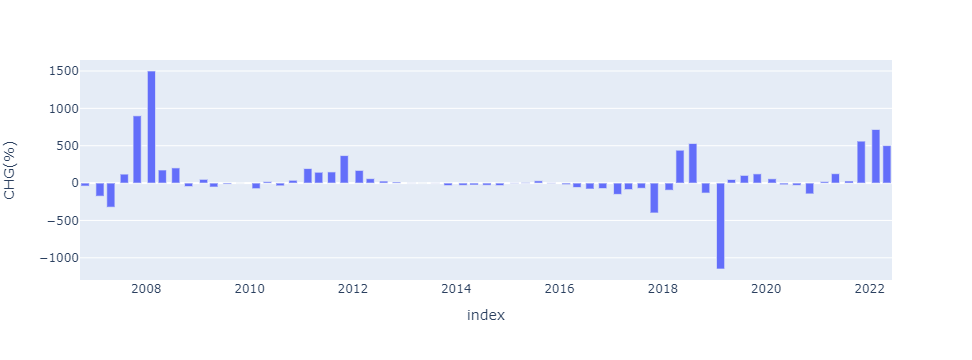

            Current Year EPS  Previous Year EPS  CHG(%)
2022-05-04              4.21               0.70  501.43
2022-02-15              3.27               0.40  717.50
2021-11-03             -0.86              -0.13  561.54
2021-08-09              1.14               0.89   28.09
2021-05-05              0.70               0.31  125.81
...                      ...                ...     ...
2007-10-29              0.30               0.03  900.00
2007-07-30              0.33               0.15  120.00
2007-04-26              0.20              -0.09 -322.22
2007-02-08              0.03              -0.04 -175.00
2006-10-26              0.03               0.05  -40.00

[63 rows x 3 columns]


In [4]:
############### compare EPS with the previous year EPS ####################
earning_tmp1 = si.get_earnings_history(ticker)
earning_tmp2 = pd.DataFrame(earning_tmp1)
earnnona = earning_tmp2.dropna()
eps_act = np.array(earnnona['epsactual'])
eps_dat = earnnona['startdatetime']
eps_chg_pry = np.round((eps_act[:-4] - eps_act[4:])/eps_act[4:]*100, 2)
eps_smry = pd.DataFrame([eps_act[:-4],eps_act[4:], eps_chg_pry]).T
eps_smry.columns = ['Current Year EPS', 'Previous Year EPS', 'CHG(%)']
eps_smry.index = [dat[:10] for dat in eps_dat[:-4]]
eps_smry_sub = eps_smry.iloc[:, :]

# plot EPS change %
fig = px.bar(eps_smry_sub, x = eps_smry_sub.index, y = 'CHG(%)')
fig.show()

print(eps_smry_sub)

In [5]:
################ basic info #####################
variables = ['revenueGrowth', 'targetLowPrice', 'targetMedianPrice', \
'targetHighPrice', 'forwardPE', 'trailingPE', 'priceToBook', 'pegRatio', \
'quickRatio', 'shortRatio', 'payoutRatio', 'dividendYield', \
'enterpriseToRevenue', 'heldPercentInstitutions', 'beta', 'recommendationKey']

skinfo = stock.info
info = list(map(skinfo.get, variables))
basic_info = pd.DataFrame(info)
basic_info.index = variables
basic_info.columns = ['Value']
basic_info

Value
revenueGrowth                1.305
targetLowPrice                  93
targetMedianPrice              110
targetHighPrice                142
forwardPE                 8.179984
trailingPE               24.231276
priceToBook                6.65203
pegRatio                      0.09
quickRatio                   1.484
shortRatio                    1.43
payoutRatio                 0.1548
dividendYield               0.0148
enterpriseToRevenue          3.822
heldPercentInstitutions    0.93225
beta                      1.027941
recommendationKey              buy

In [18]:
############## discount cash flow ############
unit = 'year'

if unit == 'quart':
    csh = stock.quarterly_cashflow
elif unit == 'year':
    csh = stock.cashflow
    
period = 15
fcsh = csh.loc['Total Cash From Operating Activities', :] + csh.loc['Capital Expenditures', :]
fcsh_chg = [(fcsh[i] - fcsh[i+1])/fcsh[i+1] for i in range(len(fcsh)-1)]
max_chg = np.max(fcsh_chg)
ave_chg = np.mean(fcsh_chg)
fcsh_ft = [fcsh[0]*(1+ave_chg)**n for n in range(period)]
csh_cur = np.sum([fcsh_ft[n-1]/(1+0.0177)**n for n in range(1, period+1)])/10**9
print(fcsh)
print(csh_cur)


2021-12-31   -2.024000e+09
2020-12-31   -1.104000e+09
2019-12-31   -1.170000e+08
2018-12-31    3.680000e+08
dtype: float64
-160942658.7718528


In [6]:
########### functions ############
## simple moving average
def fsma(price, days):
    smas = [np.mean(price[i:(i+days)]) for i in range(len(price)-days+1)]
    return smas

## exponential moving average
def fema(price, smooth, days):
    emas = [np.sum(price[:days])/days]
    for i in range(1, len(price[days:])):
        ema = price[i]*smooth/(1+days) + emas[i-1]*(1 - smooth/(1+days))
        emas.append(ema)
    return emas

## relative strength index
def frsi(price, days):
    gainloss = [(price[i+1] - price[i])/price[i] for i in range(len(price)-1)]
    gain_ave1 = sum([gl for gl in gainloss[:days] if gl >= 0])/days
    loss_ave1 = sum([gl for gl in gainloss[:days] if gl < 0])/days
    gain_aves = [gain_ave1]
    loss_aves = [loss_ave1]

    gainloss_rsi = gainloss[14:]
    for i in range(1, len(gainloss_rsi)):

        if gainloss_rsi[i] >= 0:
            cg = gainloss_rsi[i]
            cl = 0
        elif gainloss_rsi[i] < 0:
            cg = 0
            cl = gainloss_rsi[i]

        gain_ave = (gain_aves[i-1]*(days-1) + cg)/days
        gain_aves.append(gain_ave)

        loss_ave = (loss_aves[i-1]*(days-1) + cl)/days
        loss_aves.append(loss_ave)

    rs_s = np.absolute(np.array(gain_aves)/np.array(loss_aves))
    rsis = 100 - 100/(1 + rs_s)
    return rsis

## money flow index
def fmfi(price, volumes, days):
    pos_marks = []
    neg_marks = []
    for i in range(1, len(price)):
        if price[i] >= price[i-1]:
            pos_mark = 1
            neg_mark = 0
        else:
            pos_mark = 0
            neg_mark = 1

        pos_marks.append(pos_mark)
        neg_marks.append(neg_mark)

    price_mfi = price[1:]
    volumes_mfi = volumes[1:]
    mfis = np.zeros(len(price_mfi)-days+1)
    for i in range(len(price_mfi)-days+1):
        pos_mf = np.sum(price_mfi[i:(i+days)]*volumes_mfi[i:(i+days)]*pos_marks[i:(i+days)])
        neg_mf = np.sum(price_mfi[i:(i+days)]*volumes_mfi[i:(i+days)]*neg_marks[i:(i+days)])
        mfr = pos_mf/neg_mf
        mfis[i] = 100 - 100/(1+mfr)
    return mfis


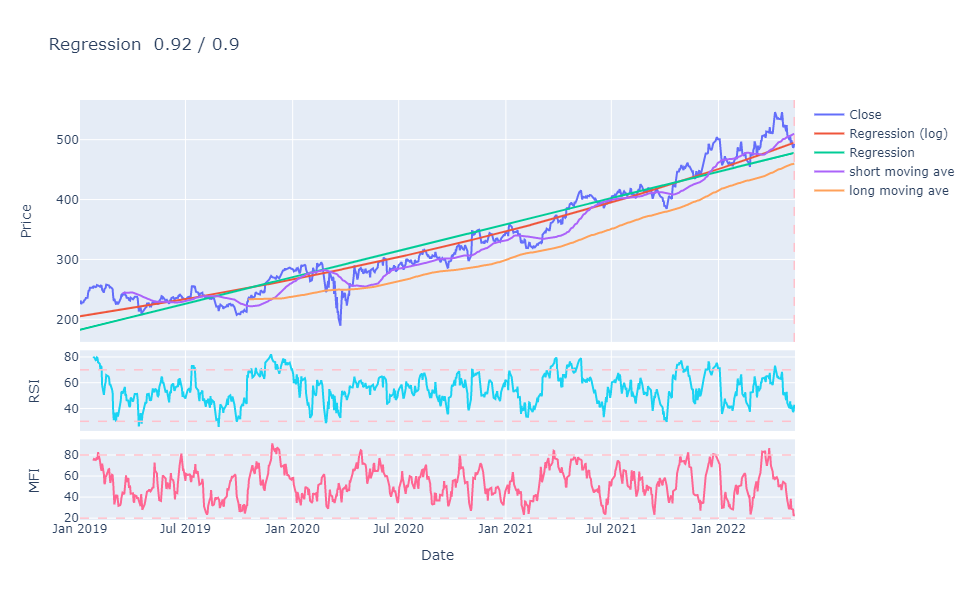

In [7]:
############### price range ####################
tdy = dt.datetime.today()
stdate = '2019-01-01'
eddate_tr = tdy
eddate_te = tdy

ma_type = 'sma'
preddays = 0  # future for prediction
mapd = (50, 200)  # (short, long) moving average period

# stock prices
stock = yf.Ticker(ticker)
skhist_tr = stock.history(start = stdate, end = eddate_tr).dropna()
skhist_te = stock.history(start = stdate, end = eddate_te).dropna()
skhigh_tr = skhist_tr['High']
sklow_tr = skhist_tr['Low']
skclose_tr = skhist_tr['Close']
skhigh_te = skhist_te['High']
sklow_te = skhist_te['Low']
skclose_te = skhist_te['Close']
sktyp_te = (skhigh_te + sklow_te + skclose_te)/3
skgl_te = [(skclose_te[i+1] - skclose_te[i])/skclose_te[i] for i in range(len(skclose_te)-1)]
skvol_te = skhist_te['Volume']

# dates
dates_tr = skhist_tr.index
dates_te = skhist_te.index

# moving average
if ma_type == 'sma':
    mashort = fsma(price = skclose_te, days = mapd[0])
    malong = fsma(price = skclose_te, days = mapd[1])

elif ma_type == 'ema':
    mashort = fema(price = skclose_te, smooth = 2, days = mapd[0])
    malong = fema(price = skclose_te, smooth = 2, days = mapd[1])

# create index for regression
time_tr = np.array((dates_tr - dates_tr[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
time_te = np.array((dates_te - dates_te[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
pred_tm = np.array(range(int(time_te[-1])+1, int(time_te[-1])+preddays)).reshape(-1, 1)
time_pred = np.concatenate((time_te, pred_tm))

# prediction and moving ave time for plot
tm_pred = [dt.date.fromisoformat(stdate) + dt.timedelta(days = int(time_pred[i])) for i in range(len(time_pred))]

# time for short and long moving average
tm_mas = dates_te[mapd[0]:]
tm_mal = dates_te[mapd[1]:]

## regression on log(price)
reg_close_log = LinearRegression().fit(time_tr, np.log(skclose_tr))
close_score1 = np.round(reg_close_log.score(time_tr, np.log(skclose_tr)), 2)
pred_close1 = np.exp(reg_close_log.predict(time_pred))

## regression on price
reg_close = LinearRegression().fit(time_tr, skclose_tr)
close_score2 = np.round(reg_close.score(time_tr, skclose_tr), 2)
pred_close2 = reg_close.predict(time_pred)

## relative strength index
rsi = frsi(price = skclose_te, days = 14)

## money flow index
mfi = fmfi(price = sktyp_te, volumes = skvol_te, days = 14)

## plots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights = [0.6, 0.2, 0.2])

fig.add_trace(go.Scatter(x = dates_te, y = skclose_te, name = 'Close'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_pred, y = pred_close1, name = 'Regression (log)'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_pred, y = pred_close2, name = 'Regression'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_mas, y = mashort, name = 'short moving ave'), row=1, col=1)
fig.add_trace(go.Scatter(x = tm_mal, y = malong, name = 'long moving ave'),row=1, col=1)
fig.add_vline(x = dates_tr[-1], line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=1, col=1)

fig.add_trace(go.Scatter(x = dates_te[15:], y = rsi, showlegend = False), row = 2, col = 1)
fig.add_hline(y = 30, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=2, col=1)
fig.add_hline(y = 70, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=2, col=1)

fig.add_trace(go.Scatter(x = dates_te[15:], y = mfi, showlegend = False), row = 3, col = 1)
fig.add_hline(y = 20, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=3, col=1)
fig.add_hline(y = 80, line_width = 1.5, line_dash = 'dash', line_color = 'pink', row=3, col=1)

fig['layout']['xaxis3']['title'] = 'Date'
fig['layout']['yaxis']['title']='Price'
fig['layout']['yaxis2']['title']='RSI'
fig['layout']['yaxis3']['title']='MFI'
fig.update_layout(title='Regression  '+str(close_score1)+' / '+str(close_score2), width = 950, height = 600)
fig.show()

In [8]:
### RSI, MFI, Disparity analysis
# disparity
disp_short = (skclose_te[49:]/np.array(mashort)-1)*100
disp_long = (skclose_te[199:]/np.array(malong)-1)*100

####### analysis for RSI and MFI
def pctg_cut(ind, thd1, thd2):
    frac = np.mean((ind >= thd1)*(ind < thd2))
    pct = np.round(frac*100, 2)
    return pct

q_rsi = 0.05
q_mfi = 0.05
q_disp = 0.05
rsi_CrI = np.round(np.quantile(rsi[~np.isnan(rsi)], [q_rsi, 1-q_rsi]), 1)
mfi_CrI = np.round(np.quantile(mfi[~np.isnan(mfi)], [q_mfi, 1-q_mfi]), 1)
disp_CrI_s = np.round(np.quantile(disp_short, [q_disp, 1-q_disp]), 1)
disp_CrI_l = np.round(np.quantile(disp_long, [q_disp, 1-q_disp]), 1)

print('current RSI: ' + str(round(rsi[-1], 1)))
print(str(int((1-2*q_rsi)*100))+'%'+' CrI of RSI:', rsi_CrI)
print('current MFI: ' + str(round(mfi[-1], 1)))
print(str(int((1-2*q_mfi)*100))+'%'' CrI of MFI:', mfi_CrI)
print('current disparity (%): ' + str(round(disp_short[-1], 1)) + '(short), ' + str(round(disp_long[-1], 1)) + '(long)')
print(str(int((1-2*q_disp)*100))+'%'' CrI of Disparity (short):', disp_CrI_s, '%')
print(str(int((1-2*q_disp)*100))+'%'' CrI of Disparity (long):', disp_CrI_l, '%')

current RSI: 42.9
90% CrI of RSI: [36.4 74.9]
current MFI: 27.0
90% CrI of MFI: [31.2 77.2]
current disparity (%): -2.9(short), 7.5(long)
90% CrI of Disparity (short): [-6.8 11.3] %
90% CrI of Disparity (long): [ 2.2 20.2] %


In [63]:
###### beta value
def skreturn(x):
    skrt = np.array(x.diff()[1:])/np.array(x[:-1])
    return skrt

tdy = dt.datetime.today()
stdate = '2022-01-01'
eddate = tdy

ticker = 'msft'
base = yf.Ticker('^GSPC').history(start = stdate, end = eddate)
stock = yf.Ticker(ticker).history(start = stdate, end = eddate)
clbase = base['Close']
clsk = stock['Close']

rt_base = skreturn(clbase)
rt_sk = skreturn(clsk)

beta = np.cov(rt_base, rt_sk)[0][1]/np.cov(rt_base, rt_sk)[0][0]
beta

1.3010072081527033

In [17]:
##################### historical PE ratio #####################
## eps
ticker = 'cost'
stock = yf.Ticker(ticker)
earning_tmp1 = si.get_earnings_history(ticker)
earning_tmp2 = pd.DataFrame(earning_tmp1)
earning = earning_tmp2[earning_tmp2['epsestimate'].notna()]

# actual earning
earn_act = earning.dropna()

# actual eps date
earntime = earn_act['startdatetime'].str[:10]

# actual eps
eps_act = earn_act['epsactual']
eps_est = earning['epsestimate']

# actual ttm eps
eps_ttms = pd.DataFrame([np.sum(eps_act[i:(i+4)]) for i in range(0, len(eps_act)-3)])
eps_date = earntime[0:-3].reset_index(drop = True)
epsttm = pd.concat([eps_date, eps_ttms], axis = 1, ignore_index=True).iloc[::-1]
epsttm.columns = ['Date', 'epsttm']

# close prices
tdy = dt.datetime.today()
skprice = stock.history(start = earntime[0:-3].iloc[-1], end = tdy)
skclose = skprice['Close'].reset_index()

# merge close price and eps
skclose['Date'] = skclose.Date.astype('datetime64[ns]')
epsttm['Date'] = epsttm.Date.astype('datetime64[ns]')
smry_per = skclose.merge(epsttm, how = 'left', on = 'Date')

# replace nan with its corresponding eps
lepsttm = list(smry_per['epsttm'])
for i in range(1, len(lepsttm)):
    if np.isnan(lepsttm[i]):
        lepsttm[i] = lepsttm[i-1]
    else: 
        continue
smry_per['epsttm'] = lepsttm

# pe ratios
smry_per['PER'] = smry_per['Close'] / smry_per['epsttm']
smry_all = smry_per.iloc[::-1].reset_index().drop(['index'], axis=1)

EPS(TTM): 12.55 (Actual), 12.54 (EST.)
PER(TTM, YH):  35.27075
PER(TTM, CS):  34.88
1 Year
median PER, Q1, Q3: 43.57 [40.55 45.29]
intrinsic price (actual eps): 546.77
intrinsic price (est. eps): 546.34
3 Year
median PER, Q1, Q3: 38.2 [34.82 41.6 ]
intrinsic price (actual eps): 479.43
intrinsic price (est. eps): 479.05
5 Year
median PER, Q1, Q3: 34.24 [29.41 39.24]
intrinsic price (actual eps): 429.7
intrinsic price (est. eps): 429.36


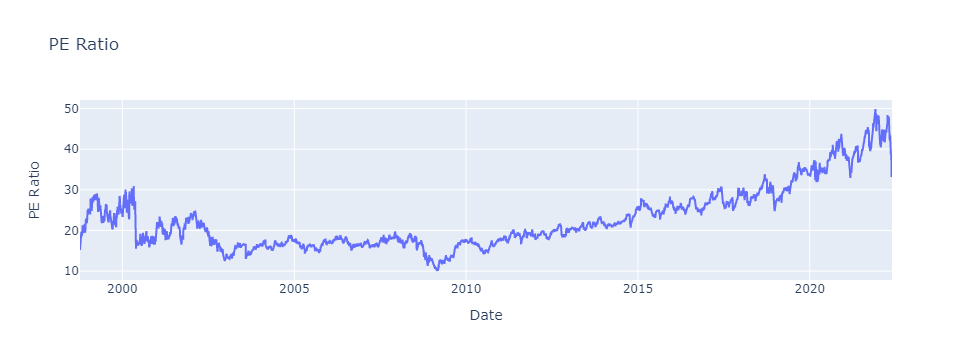

In [18]:
# summary (median per in the past five years, est. buy price)
skinfo = stock.info
trper = skinfo['trailingPE']

epsact = smry_all['epsttm'][0]
epsest = eps_est.iloc[0]+np.sum(eps_act.iloc[:3])

# summary
print('EPS(TTM):', epsact, '(Actual),', round(epsest, 2), '(EST.)')
print('PER(TTM, YH): ', trper)
print('PER(TTM, CS): ', round(smry_all['PER'][0], 2))

for ny in [1, 3, 5]:
    cutdt = min(len(smry_all['PER']), int(ny*253))
    med_per = np.median(smry_all['PER'][:cutdt])
    q13 = np.quantile(smry_all['PER'][:cutdt], [0.25, 0.75])
    estprice_act = epsact*med_per
    estprice_est = epsest*med_per
    print(ny, 'Year')
    print('median PER, Q1, Q3:', np.round(med_per, 2), np.round(q13, 2))
    print('intrinsic price (actual eps):', round(estprice_act, 2))
    print('intrinsic price (est. eps):', round(estprice_est, 2))

# plots
fig1 = go.Figure(data = go.Scatter(x = smry_all['Date'], y = smry_all['PER'], name = 'PER'))
fig1.update_layout(title='PE Ratio', xaxis_title='Date', yaxis_title='PE Ratio')
fig1.show()

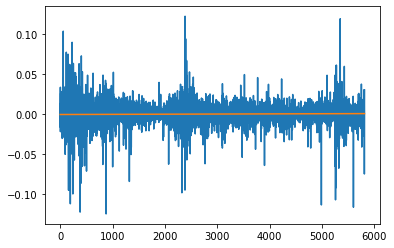

0      -0.015726
1       0.000000
2       0.009398
3       0.034450
4      -0.021602
          ...   
5807   -0.069626
5808   -0.019608
5809    0.016333
5810    0.030830
5811    0.018454
Name: PER, Length: 5812, dtype: float64

In [16]:
##### plot growth of per
pers = smry_per['PER']
perch_tmp = pers.diff()[1:]/pers[:-1]
perch = perch_tmp[~np.isnan(perch_tmp)]
indeces = np.array(range(len(perch))).reshape(-1, 1)
fit_perch = LinearRegression().fit(indeces, perch)
perch_pred = fit_perch.predict(indeces)
plt.plot(perch)
plt.plot(perch_pred)
plt.show()

np.array(pers.diff())[1:]/pers[:-1]

In [12]:
# compared with SP500 and NASDAQ100
ticker = 'cat'
periods = ['1mo', '3mo', '6mo', '1y', '2y', '5y']

def skprcchg(tk, prd):
    stock = yf.Tickers(tk+' voo qqq')
    skclose = stock.history(period = prd)['Close'].dropna()
    skchg_tmp = round((skclose.iloc[-1, :] - skclose.iloc[0, :])/skclose.iloc[0, :]*100, 2)
    skchg = pd.DataFrame(skchg_tmp).T
    return skchg

skchgs = None
for prd in periods:
    chg = skprcchg(ticker, prd)
    skchgs = pd.concat([skchgs, chg])
    
skchgs.index = periods
skchgs = skchgs[[ticker.upper(), 'VOO', 'QQQ']]
print('Stock Price CHG(%)')
skchgs

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
Stock Price CHG(%)


CAT    VOO     QQQ
1mo   -5.59  -9.29  -11.77
3mo    1.35  -9.10  -13.23
6mo   -1.72 -13.36  -22.80
1y   -13.42  -2.35   -7.10
2y    95.28  40.72   33.85
5y   127.35  82.54  125.31

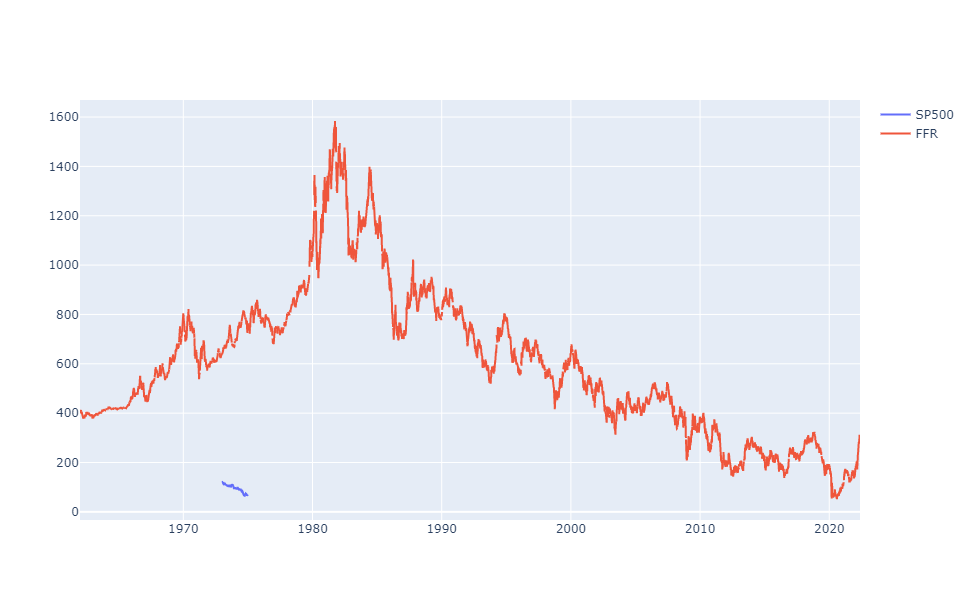

In [9]:
###### SP500 vs Federal Funds rate
# CPI (CPIAUCSL), Federal Funds Rate (FEDFUNDS), GDP (GDP), PPI (PPIACO), nemployment rate (UNRATE), 10-Y treasury (DGS10)
stock = yf.Ticker('^GSPC')
sp = stock.history(start = '1973-01-01', end = '1974-12-30')  # period = 'max'
fred = Fred(api_key='91efb88bab74a49d43c0630277e4c548')
fdata = fred.get_series('DGS10')

fig = go.Figure()
fig.add_trace(go.Scatter(x = sp.index, y = sp['Close'], name = 'SP500'))
fig.add_trace(go.Scatter(x = fdata.index, y = fdata*100, name = 'FFR'))
fig.update_layout(width = 950, height = 600)
fig.show()

In [77]:
round(np.mean(skchg['diff']), 2)

22.81